<a href="https://www.kaggle.com/code/tadesseabateneh/amharic-language-nlp?scriptVersionId=187461691" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Amharic Sentiment Analysis

## Dataset Description

In [26]:

import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers, losses
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
import spacy
from spacy.util import compounding
from spacy.util import minibatch
import warnings
warnings.filterwarnings("ignore")

In [27]:
def random_colours(number_of_colors):
    '''
    Simple function for random colours generation.
    Input:
        number_of_colors - integer value indicating the number of colours which are going to be generated.
    Output:
        Color in the following format: ['#E86DA4'] .
    '''
    colors = []
    for i in range(number_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors

In [4]:
# Suppress chained assignment warnings
pd.options.mode.chained_assignment = None

# Load datasets
def load_data(url):
    """Load data from the given URL and display the first few rows."""
    df = pd.read_csv(url)
    return df

train_url = "https://raw.githubusercontent.com/liyaSileshi/amharic-sentiment-analysis/main/data_preprocess/train.csv"
valid_url = "https://raw.githubusercontent.com/liyaSileshi/amharic-sentiment-analysis/main/data_preprocess/dev.csv"
test_url = "https://raw.githubusercontent.com/liyaSileshi/amharic-sentiment-analysis/main/data_preprocess/test.csv"

df_train = load_data(train_url)
df_valid = load_data(valid_url)
df_test = load_data(test_url)


In [5]:
df_train.head()

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1213084822521950209,neutral,NaN
1,1,1213011490372038656,neutral,ልዩ የተፈጥሮ ገፅታ \n *****\n\nየምስራቅ አፍሪካ የውሃ ማማ ጮቄ
2,2,1213763702715043840,mixed,@AbbaSheger ማንም ቢሆን የሀገሩን ጥቅም አሳልፎ አይሰጥም። ያ መላ...
3,3,1213764224356421633,neutral,ብ/ጄ አሳምነው ጽጌ ከምክትል ጠ/ሚ ደመቀ ጋር በሱዳን ጉብኝት አልበሽር ...
4,4,1212766574337150976,positive,NaN


In [6]:
df_valid.head()

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1214005466675777536,neutral,RT @AyeleGelan: ድሮ ተሸምድደው በቀላሉ ይንበለበሉ የነበሩ ኢህኣ...
1,1,1213261378397409280,mixed,ኦሮሞ ልምድ የለውም ካልን ሌላውም ያው ይሆናል ዋናውነገር ፍትህን ማውረድ...
2,2,1213846984349626369,neutral,እስክንድር ነጋ ባለአደራው ምክርቤት ለአንድ ብሄር እና ለአንድ ሃይማኖት ...
3,3,1216365312561635333,positive,@Gfasil በረከት በላይነህ \nየእያዪ ፈንገስ ትያትር ደራሲ\nእንዲሁም...
4,4,1213234381768265728,neutral,NaN


In [7]:
df_test.head()

,Unnamed: 0,tweet_id,sentiment,tweet
0,0,1213842050455654402,neutral,@Haymana_ እንደዛ ካልሆነ በስተቀር ሰውዬው ማንንም አይቦልኩም
1,1,1215480766295171072,neutral,NaN
2,2,1222950264812064768,positive,ለመገናኛ ብዙሃን አባላት!\n\nበደምቢዶሎ የታገቱ ኢትዮጵያውያን ድምፅ ለ...
3,3,1213967203076395009,negative,NaN
4,4,1213961696840171521,neutral,NaN


In [8]:
df_train.shape, df_valid.shape, df_test.shape

((7511, 4), (939, 4), (939, 4))

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5764 entries, 0 to 5763
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5764 non-null   int64 
 1   tweet_id    5764 non-null   int64 
 2   sentiment   5764 non-null   object
 3   tweet       5764 non-null   object
dtypes: int64(2), object(2)
memory usage: 180.2+ KB


In [13]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738 entries, 0 to 737
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  738 non-null    int64 
 1   tweet_id    738 non-null    int64 
 2   sentiment   738 non-null    object
 3   tweet       738 non-null    object
dtypes: int64(2), object(2)
memory usage: 23.2+ KB


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  516 non-null    int64 
 1   tweet_id    516 non-null    int64 
 2   sentiment   516 non-null    object
 3   tweet       516 non-null    object
dtypes: int64(2), object(2)
memory usage: 16.2+ KB


In [9]:
# drop "mixed" sentiment from df_train, df_valid and df_test
df_train = df_train[df_train["sentiment"].str.contains("mixed")==False]
df_test = df_test[df_test["sentiment"].str.contains("mixed")==False]
df_valid = df_valid[df_valid["sentiment"].str.contains("mixed")==False]

In [10]:
# Data Cleaning
def clean_df(df):
    """Remove null values and duplicate rows, then reset the index."""
    df = df.dropna()
    df = df.drop_duplicates(subset='tweet_id', keep="first")
    df = df.reset_index(drop=True)
    return df

df_train = clean_df(df_train)
df_valid = clean_df(df_valid)
df_test = clean_df(df_test)


In [11]:
df_train.shape, df_valid.shape, df_test.shape

((5764, 4), (738, 4), (516, 4))

In [15]:
def clean_text(text, options):
    """Clean text by removing URLs, mentions, emojis, and converting to lowercase."""
    if options['lowercase']:
        text = text.lower()
    if options['remove_url']:
        text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    if options['remove_mentions']:
        text = re.sub("@[A-Za-z0-9_]+","", text)
    if options['demojify']:
        emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"
            u"\U0001F300-\U0001F5FF"
            u"\U0001F680-\U0001F6FF"
            u"\U0001F1E0-\U0001F1FF"
            u"\U00002500-\U00002BEF"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642"
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"
            u"\u3030"
            "]+", re.UNICODE)
        text = re.sub(emoji_pattern, '', text)
    if options['remove_punctuation']:
        text = text.translate(str.maketrans('', '', string.punctuation))
    if options['remove_numbers']:
        text = re.sub(r'\d+', '', text)
    return text

clean_config = {
    'remove_url': True,
    'remove_mentions': True,
    'lowercase': True,
    'demojify': True,
    'remove_punctuation': True,
    'remove_numbers': True
}

df_train['tweet'] = df_train['tweet'].apply(clean_text, args=(clean_config,))
df_valid['tweet'] = df_valid['tweet'].apply(clean_text, args=(clean_config,))
df_test['tweet'] = df_test['tweet'].apply(clean_text, args=(clean_config,))


In [16]:
def normalize_char_level_missmatch(input_token):
    """Normalize character level mismatches in Amharic text."""
    patterns = {
        '[ሃኅኃሐሓኻ]': 'ሀ', '[ሑኁዅ]': 'ሁ', '[ኂሒኺ]': 'ሂ', '[ኌሔዄ]': 'ሄ', '[ሕኅ]': 'ህ',
        '[ኆሖኾ]': 'ሆ', '[ሠ]': 'ሰ', '[ሡ]': 'ሱ', '[ሢ]': 'ሲ', '[ሣ]': 'ሳ', '[ሤ]': 'ሴ',
        '[ሥ]': 'ስ', '[ሦ]': 'ሶ', '[ዓኣዐ]': 'አ', '[ዑ]': 'ኡ', '[ዒ]': 'ኢ', '[ዔ]': 'ኤ',
        '[ዕ]': 'እ', '[ዖ]': 'ኦ', '[ጸ]': 'ፀ', '[ጹ]': 'ፁ', '[ጺ]': 'ፂ', '[ጻ]': 'ፃ',
        '[ጼ]': 'ፄ', '[ጽ]': 'ፅ', '[ጾ]': 'ፆ', '(ሉ[ዋአ])': 'ሏ', '(ሙ[ዋአ])': 'ሟ',
        '(ቱ[ዋአ])': 'ቷ', '(ሩ[ዋአ])': 'ሯ', '(ሱ[ዋአ])': 'ሷ', '(ሹ[ዋአ])': 'ሿ', '(ቁ[ዋአ])': 'ቋ',
        '(ቡ[ዋአ])': 'ቧ', '(ቹ[ዋአ])': 'ቿ', '(ሁ[ዋአ])': 'ኋ', '(ኑ[ዋአ])': 'ኗ', '(ኙ[ዋአ])': 'ኟ',
        '(ኩ[ዋአ])': 'ኳ', '(ዙ[ዋአ])': 'ዟ', '(ጉ[ዋአ])': 'ጓ', '(ደ[ዋአ])': 'ዷ', '(ጡ[ዋአ])': 'ጧ',
        '(ጩ[ዋአ])': 'ጯ', '(ጹ[ዋአ])': 'ጿ', '(ፉ[ዋአ])': 'ፏ', '[ቊ]': 'ቁ', '[ኵ]': 'ኩ'
    }
    for pattern, replacement in patterns.items():
        input_token = re.sub(pattern, replacement, input_token)
    return input_token

df_train['tweet'] = df_train['tweet'].apply(normalize_char_level_missmatch)
df_valid['tweet'] = df_valid['tweet'].apply(normalize_char_level_missmatch)
df_test['tweet'] = df_test['tweet'].apply(normalize_char_level_missmatch)


## Exploratory Data Analysis

In [17]:
df_train.describe()

,Unnamed: 0,tweet_id
count,5764.000000,5.764000e+03
mean,3761.851145,1.211451e+18
std,2175.509178,5.181197e+15
min,1.000000,1.200913e+18
25%,1877.750000,1.212294e+18
50%,3763.500000,1.212968e+18
75%,5656.750000,1.213938e+18
max,7509.000000,1.278426e+18


In [18]:
df_train.head()

,Unnamed: 0,tweet_id,sentiment,tweet
0,1,1213011490372038656,neutral,ልዩ የተፈጥሮ ገፅታ \n \n\nየምስራቅ አፍሪካ የውሀ ማማ ጮቄ
1,3,1213764224356421633,neutral,ብጄ አሳምነው ፅጌ ከምክትል ጠሚ ደመቀ ጋር በሱዳን ጉብኝት አልበሽር ያሉ...
2,5,1212723914494877698,neutral,the only part i likeትልልቅ የነዳጅ ፍጆታ ያላቸው ተሽከርካሪ...
3,6,1201007355607040001,neutral,እሺ ወንድሜ እተከላለሁ ማኛ እኮ ናት ወዳታለሁ በጣም ደሞ ቅና አሉህ
4,7,1213183031638405123,neutral,ይቺን አውቆ ነው ዶር አብይ ክርስቲያን የሆነዋኧረ ጀንፈሉ ይህ እንጣጥ ...


## Dataset Distribution

In [19]:
temp = df_train.groupby('sentiment').count()['tweet'].reset_index().sort_values(by='tweet',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,tweet
1,neutral,2987
0,negative,1491
2,positive,1286


<Axes: xlabel='sentiment', ylabel='count'>

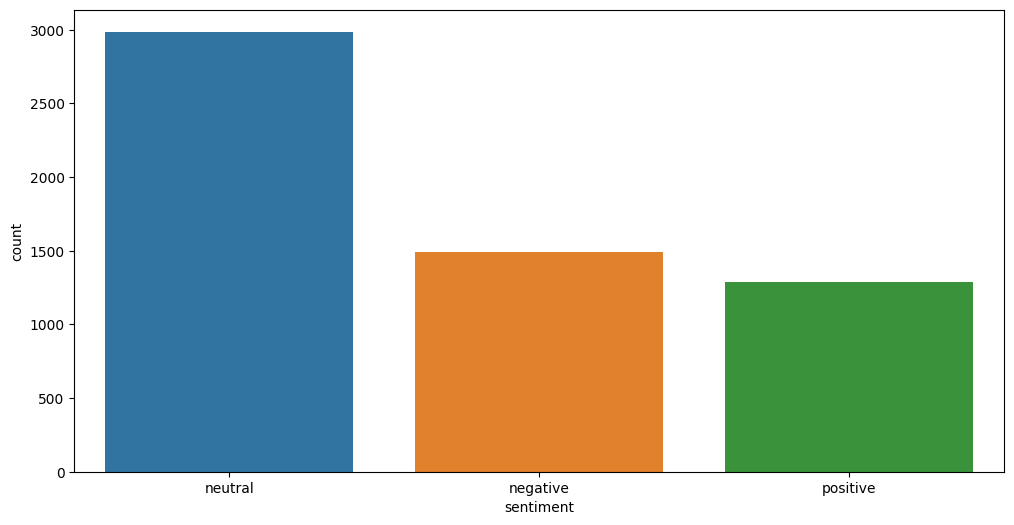

In [28]:
plt.figure(figsize=(12,6))
sns.countplot(x='sentiment',data=df_train)

In [29]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.tweet,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

## Most Common Words

In [32]:
df_train['temp_list'] = df_train['tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,ነው,1747
1,እና,732
2,ላይ,708
3,ነው።,471
4,ግን,372
5,rt,351
6,ሰው,335
7,ምን,330
8,ነገር,316
9,ብቻ,311


In [33]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Selected Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [34]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

## Most Common Words Sentiment Wise

In [35]:
Positive_sent = df_train[df_train['sentiment']=='positive']
Negative_sent = df_train[df_train['sentiment']=='negative']
Neutral_sent = df_train[df_train['sentiment']=='neutral']

In [36]:
# Most common positive words
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,ነው,286
1,እና,151
2,ነው።,114
3,ላይ,98
4,መልካም,96
5,ጋር,87
6,እንኳን,86
7,rt,80
8,ሰው,73
9,አሜን,71


In [37]:
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [38]:
# Most common negative words
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,ላይ,204
2,እና,162
3,ነው።,129
4,ምን,122
5,ብቻ,108
6,ሰው,106
7,ግን,94
8,ነገር,85
9,ህዝብ,83
10,rt,82


In [40]:
fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Negative Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [41]:
#Most common Neutral words
top = Counter([item for sublist in Neutral_sent['temp_list'] for item in sublist])
temp_neutral = pd.DataFrame(top.most_common(20))
temp_neutral = temp_neutral.loc[1:,:]
temp_neutral.columns = ['Common_words','count']
temp_neutral.style.background_gradient(cmap='Reds')

,Common_words,count
1,እና,419
2,ላይ,406
3,ነው።,228
4,ግን,220
5,rt,189
6,ምን,178
7,ነገር,167
8,ጋር,163
9,ሰው,156
10,ብቻ,153


In [42]:
fig = px.bar(temp_neutral, x="count", y="Common_words", title='Most Commmon Neutral Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

## Unique Words in Each Segment

In [44]:
df_train['temp_list1'] = df_train['tweet'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,ነው,1747
1,እና,732
2,ላይ,708
3,ነው።,471
4,ግን,372
5,rt,351
6,ሰው,335
7,ምን,330
8,ነገር,316
9,ብቻ,311


In [45]:
raw_text = [word for word_list in df_train['temp_list1'] for word in word_list]

In [48]:
def words_unique(sentiment,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in df_train[df_train.sentiment != sentiment]['temp_list1']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df_train[df_train.sentiment == sentiment]['temp_list1']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

### Postive Tweets

In [49]:
Unique_Positive= words_unique('positive', 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_Positive.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,በርታልን,7
1,መሪዬ,7
2,ይመስገን,7
3,ቫይረስ,4
4,ይሁንላችሁ,4
5,ክብርት,4
6,ውብ,4
7,ብሎኛል,4
8,ይስጥልኝ,4
9,ትኑር,4


In [50]:
fig = px.treemap(Unique_Positive, path=['words'], values='count',title='Tree Of Unique Positive Words')
fig.show()

### Negative Tweets

In [51]:
Unique_Negative= words_unique('negative', 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_Negative.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,ዱቄት,6
1,የለሽ,6
2,እንጨት,5
3,ዝርፊያ,5
4,ለሊት,5
5,የሰጡት,4
6,ባክሽ,4
7,ድርቅ,4
8,መሰለህ,4
9,ንህና,4


In [53]:
fig = px.treemap(Unique_Negative, path=['words'], values='count',title='Tree Of Unique Negative Words')
fig.show()

### Neutral Tweets

In [54]:
Unique_Neutral= words_unique('neutral', 10, raw_text)
print("The top 10 unique words in Neutral Tweets are:")
Unique_Neutral.style.background_gradient(cmap='Oranges')

The top 10 unique words in Neutral Tweets are:


,words,count
0,ይመስለኛል,10
1,ብላቹ,9
2,ጥያቄው,8
3,ስርአተ,8
4,ወዴት,8
5,ግምገማዎች,8
6,የብሄራዊ,8
7,ፕሪምየር,8
8,ኳ,8
9,የጎንደር,7


In [55]:
fig = px.treemap(Unique_Neutral, path=['words'], values='count',title='Tree Of Neutral Positive Words')
fig.show()

## Tokenization and Vectorization

In [62]:
# Tokenization and Vectorization
X_train, y_train = df_train['tweet'].values, df_train['sentiment'].values
X_test, y_test = df_test['tweet'].values, df_test['sentiment'].values

vectorizer = CountVectorizer(analyzer='word', max_features=1000, ngram_range=(1, 3))
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()


In [63]:
# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train['tweet'])

X_train = tokenizer.texts_to_sequences(df_train['tweet'])
X_valid = tokenizer.texts_to_sequences(df_valid['tweet'])
X_test = tokenizer.texts_to_sequences(df_test['tweet'])

max_length = 100
X_train_padded = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_valid_padded = pad_sequences(X_valid, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

# Label Encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['sentiment'])
y_valid = label_encoder.transform(df_valid['sentiment'])
y_test = label_encoder.transform(df_test['sentiment'])

In [64]:
df_train.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [65]:
# Naive Bayes Classifier 
classifier = GaussianNB()
classifier.fit(X_train_padded, y_train)
y_pred = classifier.predict(X_test_padded)

In [66]:
# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Naive Bayes Accuracy: {accuracy:.2f}")
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Naive Bayes Accuracy: 0.23
Naive Bayes Classification Report:
              precision    recall  f1-score   support

    negative       0.38      0.02      0.04       144
     neutral       0.33      0.00      0.01       251
    positive       0.23      0.97      0.37       121

    accuracy                           0.23       516
   macro avg       0.31      0.33      0.14       516
weighted avg       0.32      0.23      0.10       516



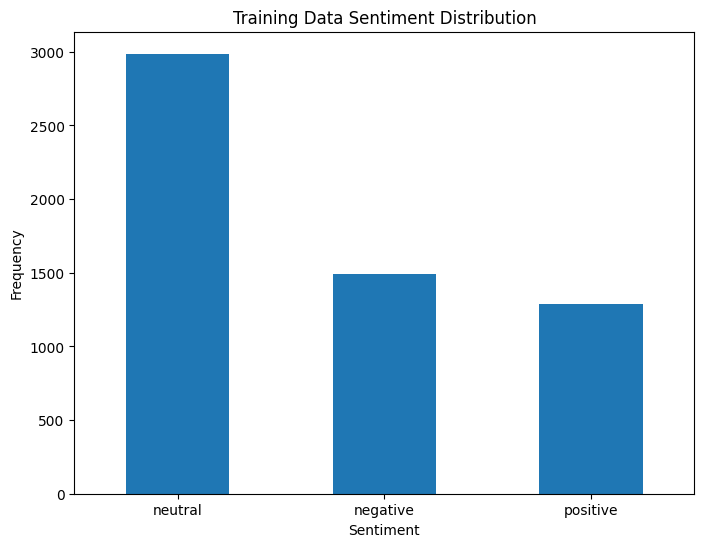

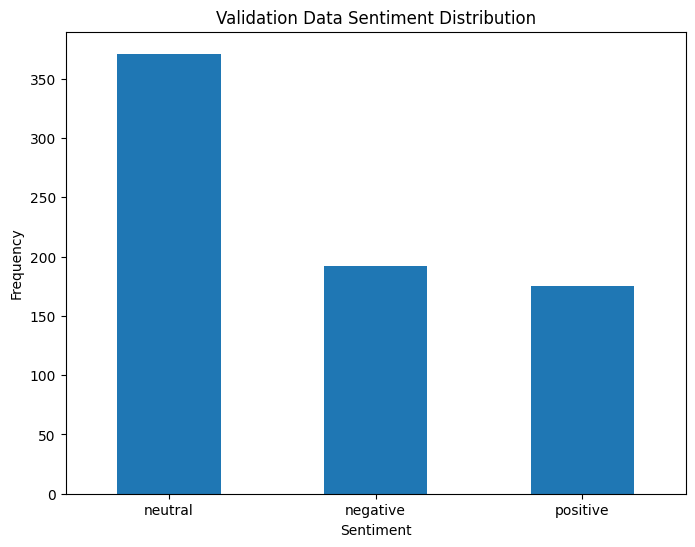

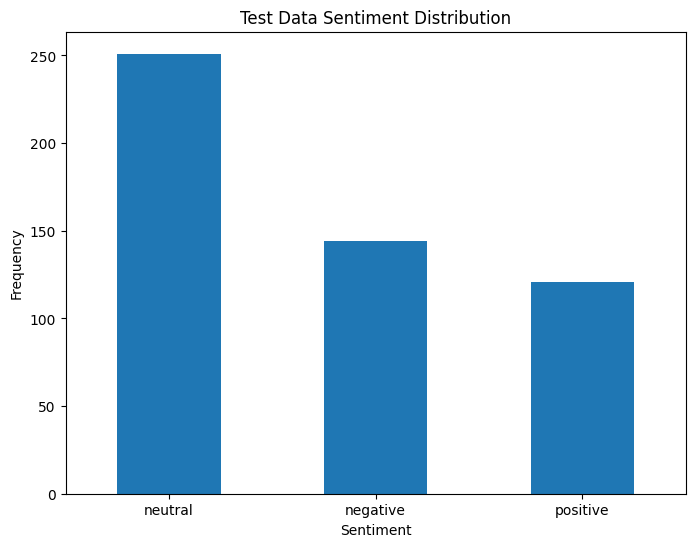

In [67]:
# Visualization
def plot_sentiment_distribution(df, title):
    """Plot the distribution of sentiment labels."""
    sentiment_counts = df['sentiment'].value_counts()
    plt.figure(figsize=(8, 6))
    sentiment_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel('Sentiment')
    plt.ylabel('Frequency')
    plt.xticks(rotation=0)
    plt.show()

plot_sentiment_distribution(df_train, "Training Data Sentiment Distribution")
plot_sentiment_distribution(df_valid, "Validation Data Sentiment Distribution")
plot_sentiment_distribution(df_test, "Test Data Sentiment Distribution")

# Neural Network with Embedding

In [68]:
# Neural Network Model with Embedding
def create_model(vocab_size, embedding_dim):
    """Create a simple neural network model for text classification."""
    model = tf.keras.Sequential([
        layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    return model


In [69]:
# Parameters
vocab_size = 10000
embedding_dim = 64

model = create_model(vocab_size, embedding_dim)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [71]:
# Training the Model
history = model.fit(X_train_padded, y_train, epochs=100, validation_data=(X_valid_padded, y_valid), verbose=2)


Epoch 1/100
181/181 - 1s - 6ms/step - accuracy: 0.8126 - loss: 0.4788 - val_accuracy: 0.5054 - val_loss: 1.2177
Epoch 2/100
181/181 - 1s - 6ms/step - accuracy: 0.8258 - loss: 0.4481 - val_accuracy: 0.5217 - val_loss: 1.1382
Epoch 3/100
181/181 - 1s - 6ms/step - accuracy: 0.8541 - loss: 0.3852 - val_accuracy: 0.4797 - val_loss: 1.2764
Epoch 4/100
181/181 - 1s - 6ms/step - accuracy: 0.8517 - loss: 0.3714 - val_accuracy: 0.4797 - val_loss: 1.2870
Epoch 5/100
181/181 - 1s - 6ms/step - accuracy: 0.8751 - loss: 0.3330 - val_accuracy: 0.4593 - val_loss: 1.3821
Epoch 6/100
181/181 - 1s - 6ms/step - accuracy: 0.8923 - loss: 0.2903 - val_accuracy: 0.5230 - val_loss: 1.6410
Epoch 7/100
181/181 - 1s - 6ms/step - accuracy: 0.9020 - loss: 0.2677 - val_accuracy: 0.4743 - val_loss: 1.4430
Epoch 8/100
181/181 - 1s - 6ms/step - accuracy: 0.9046 - loss: 0.2641 - val_accuracy: 0.4973 - val_loss: 1.5836
Epoch 9/100
181/181 - 1s - 6ms/step - accuracy: 0.9098 - loss: 0.2403 - val_accuracy: 0.4797 - val_loss:

In [72]:
# Evaluate the Model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.2f}")


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5058 - loss: 3.5171 
Test Accuracy: 0.50


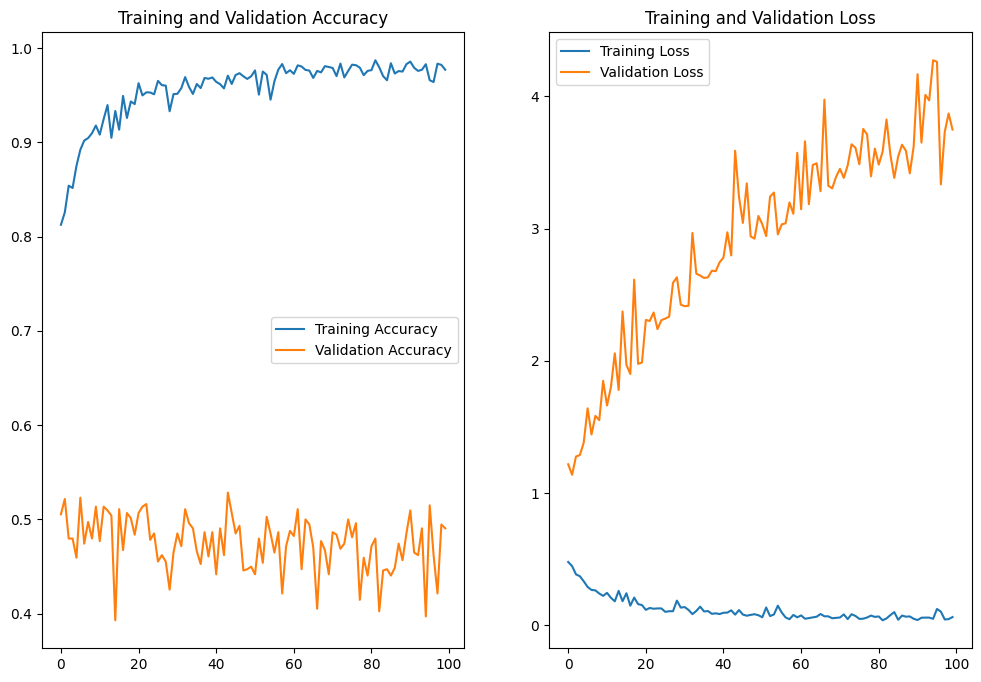

In [73]:
# Plotting Training History
def plot_training_history(history):
    """Plot training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

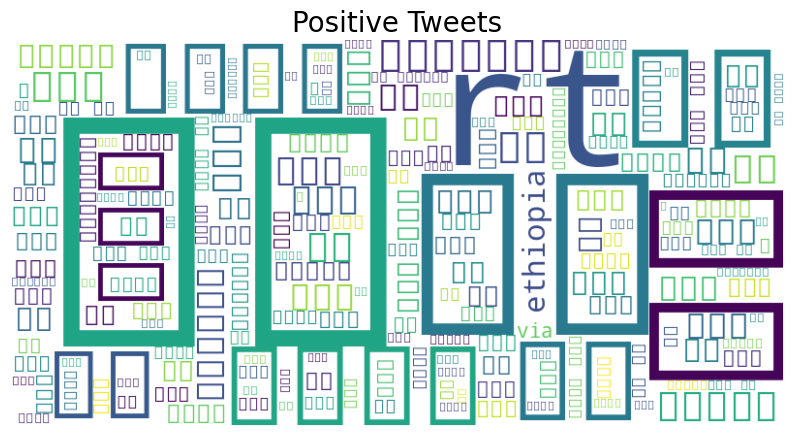

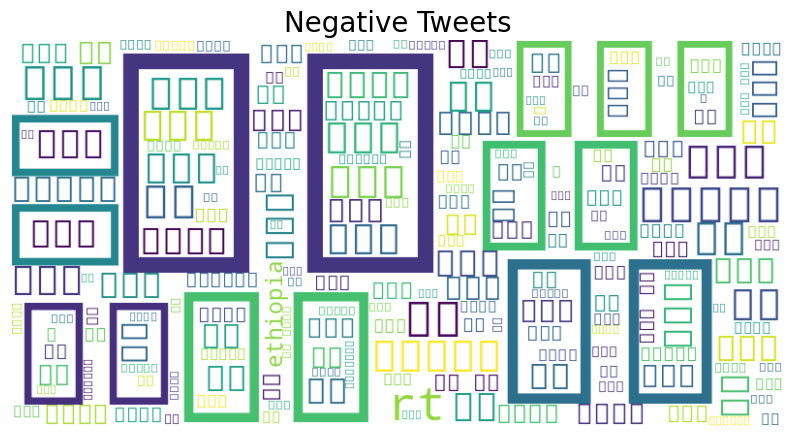

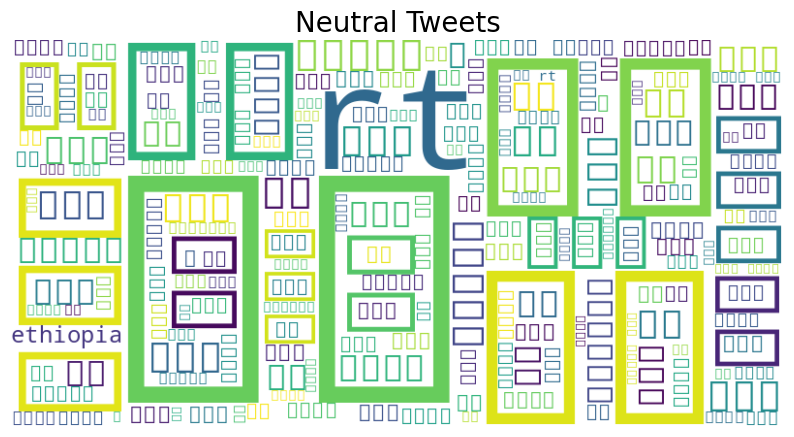

In [74]:
from wordcloud import WordCloud

# Function to plot WordCloud
def plot_wordcloud(text, title):
    """Plot WordCloud for given text."""
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, size=20)
    plt.axis('off')
    plt.show()

# Plot WordCloud for each sentiment
plot_wordcloud(df_train[df_train['sentiment'] == 'positive']['tweet'], 'Positive Tweets')
plot_wordcloud(df_train[df_train['sentiment'] == 'negative']['tweet'], 'Negative Tweets')
plot_wordcloud(df_train[df_train['sentiment'] == 'neutral']['tweet'], 'Neutral Tweets')
